<a href="https://colab.research.google.com/github/epic-coder97/DATA-690-FDS--CW/blob/main/FDS_Project_Komal_Nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project title - GDP Prediction using World Bank Data

For this analysis, the following API has been selected: https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-api-documentation

The World Bank data consists of demographic and other statistical data related to Population, Employment, Health, GDP, Energy Consumption, etc. for 120 different countries from the year 1990 to 2021. These categories are called indicators and are each defined by a code.

The following indicators have been chosen for the project:
- SP.POP.TOTL - Total Population

- SP.POP.TOTL.FE.IN - Total Female Population

- SP.POP.TOTL.MA.IN - Total Male Population

- SE.COM.DURS - Compulsory Education Duration

- SL.IND.EMPL.ZS - Employment in Industry(%)

- SL.AGR.EMPL.ZS - Employment in Agriculture(%)

- SL.UEM.TOTL.ZS - Unemployment(%)

- NY.GDP.MKTP.CD - GDP in USD

- NY.ADJ.NNTY.PC.KD.ZG - National Income per Capita

- NY.GSR.NFCY.CD - Net income from Abroad


For now we have taken data of 4 different countries for 31 years i.e. from 1990 to 2021 to predict GDP namely -
- USA
- China
- Russia
- India

Problem statement -
- How is 'GDP in USD' affected for the 4 countries in 31 years?
- What factors are responsible for the rise/decline in the GDP? Are they positively correlated or negatively correlated?
- Implement time series analysis on GDP data and try to find out if the series is stationary or not using ACF value and ADF test. If not stationary, make it stationary.
- Check whether the GDP is normally distributed using QQ Plot.
- Apply machine learning algorithm to predict the GDP in USD
- Visualize actual vs predicted values.

# Task 1 - Data Gathering

In [ ]:
!pip3 install world_bank_data

In [ ]:
import pandas as pd
import numpy as np
import requests

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Base URL used in all the API calls
BASE_URL='http://api.worldbank.org/v2/'

# List of indicators according to the features defined above
INDICATOR_CODES=['SP.POP.TOTL', 'SP.POP.TOTL.FE.IN', 'SP.POP.TOTL.MA.IN',
 'SE.COM.DURS',
 'SL.IND.EMPL.ZS', 'SL.AGR.EMPL.ZS', 'SL.UEM.TOTL.ZS',
 'NY.GDP.MKTP.CD',
 'NY.ADJ.NNTY.PC.KD.ZG', 'NY.GSR.NFCY.CD']

COUNTRY_LIST=['USA', 'India', 'China', 'Russia']


In [ ]:
# mapping of feature codes to more meaningful names
featureMap={
    "SP.POP.TOTL": "Total Population",
    "SP.POP.TOTL.FE.IN": "Female Population",
    "SP.POP.TOTL.MA.IN": "Male Population",
    "SE.COM.DURS": "Compulsory Education Dur.",
    "SL.IND.EMPL.ZS":"Employment in Industry(%)",
    "SL.AGR.EMPL.ZS": "Employment in Agriculture(%)",
    "SL.UEM.TOTL.ZS": "Unemployment(%)",
    "NY.GDP.MKTP.CD": "GDP in USD",
    "NY.ADJ.NNTY.PC.KD.ZG":"National Income per Capita",
    "NY.GSR.NFCY.CD":"Net income from Abroad"
}

# Mapping of country codes to their actual names
countryMap={
    "US": "USA",
    "IN":"India",
    "CN": "China",
    "RU": "Russia"
}

In [ ]:
# constant parameters used in sending the request.
params = dict()
# to ensure we receive a JSON response
params['format']='json'
# The data we fetch is for 59 years.
# Hence we change the default page size of 50 to 100 to ensure we need only one API call per feature.
params['per_page']='100'
# Range of years for which the data is needed
params['date']='1990:2021'

In [ ]:
# Function to get JSON data from the endpoint
def loadJSONData(country_code): 
    dataList=[]
    
    # iterate over each indicator code specified in the contant INDICATOR_CODES defined above
    for indicator in INDICATOR_CODES: 
        
        # form the URL in the desired format
        # E.g: http://api.worldbank.org/v2/countries/us/indicators/SP.POP.TOTL?format=json&per_page=200&date=1990:2021
        url=BASE_URL+'countries/'+country_code.lower()+'/indicators/'+indicator
        
        # send the request using the resquests module
        response = requests.get(url, params=params)

            
        # list of values for one feature
        indicatorVals=[]
        for obj in response.json()[1]:
            
            # check for empty values
            if obj['value'] is "" or obj['value'] is None:
                indicatorVals.append(None)
            else:
            # if a value is present, add it to the list of indicator values
                indicatorVals.append(float(obj['value']))
        dataList.append(indicatorVals)
            
    # Once all the features have been obtained, add the values for the "Year"
    # The API returns the indicator values from the most recent year. Hence, we create a list of years in reverse order
    dataList.append([year for year in range(2021, 1990, -1)])
    # return the list of lists of feature values [[val1,val2,val3...], [val1,val2,val3...], [val1,val2,val3...], ...]
    return dataList

In [ ]:
# function to invokde the loadJSONData function and form the final DataFrame for each country
def getCountrywiseDF(country_code):
    
    # The resulting dataframe needs to have meaningful column names
    # hence we create a list of column names from the map defined above
    col_list=list(featureMap.values())
    # append the year column name
    col_list.append('Year')
    
    print("------------------Loading data for: "+countryMap[country_code]+"-----------------------")
    
    # for the given country call the loadJSONData function and fetch the data from the API
    dataList=loadJSONData(country_code)
    
    # transform the list of lists of features into a DataFrame
    # np.column_stack is used to add each list as a column 
    df=pd.DataFrame(np.column_stack(dataList), columns=col_list)
    
    # add the country column by extracting the country name from the map using the country code
    df['Country'] = countryMap[country_code]
    
    # display the resulting dataframe
    display(df.head())
    
    # return the formed dataframe for the given country
    return df


In [ ]:
# Call the getCountrywiseDF function with the code of each country under consideration
# We will have a seperate dataframe for each country - 7 data frames

US_df=getCountrywiseDF('US')
IN_df=getCountrywiseDF('IN')
CN_df=getCountrywiseDF('CN')
RU_df=getCountrywiseDF('RU')


print("Data Loading Completed")

------------------Loading data for: USA-----------------------


,Total Population,Female Population,Male Population,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Year,Country
0,329484123.0,166449500.0,163034623.0,12.0,None,None,8.05,20953030000000.0,None,222340000000.0,2021,USA
1,328329953.0,165867325.0,162462628.0,12.0,19.91,1.36,3.67,21433224697000.0,1.919556,266415000000.0,2020,USA
2,326838199.0,165118706.0,161719493.0,12.0,19.870001,1.37,3.9,20611860934000.0,1.962241,294163000000.0,2019,USA
3,325122128.0,164262696.0,160859432.0,12.0,19.73,1.43,4.36,19542979183000.0,1.457315,294552000000.0,2018,USA
4,323071755.0,163245938.0,159825817.0,12.0,19.780001,1.43,4.87,18745075687000.0,0.173821,231944000000.0,2017,USA


------------------Loading data for: India-----------------------


,Total Population,Female Population,Male Population,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Year,Country
0,1380004385.0,662903415.0,717100970.0,8.0,None,None,7.997,2660245248867.629883,None,-24832904774.6716,2021,India
1,1366417756.0,656288184.0,710129572.0,8.0,25.120001,42.599998,5.27,2870504096717.77002,2.266046,-27238626774.052502,2020,India
2,1352642283.0,649586703.0,703055580.0,8.0,24.950001,43.330002,5.33,2701111782775.029785,5.40128,-28935365552.6301,2019,India
3,1338676779.0,642796257.0,695880522.0,8.0,24.860001,43.93,5.358,2651472946374.910156,7.257913,-28673171869.012299,2018,India
4,1324517250.0,635912563.0,688604687.0,8.0,24.74,44.560001,5.423,2294797980509.009766,6.355806,-46857856463.203697,2017,India


------------------Loading data for: China-----------------------


,Total Population,Female Population,Male Population,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Year,Country
0,1410929362.0,687245874.0,723683488.0,9.0,None,None,5.0,14722730697890.099609,None,-104389346162.764008,2021,China
1,1407745000.0,685480283.0,722264717.0,9.0,27.42,25.33,4.52,14279937467431.0,4.709598,-40009264084.3032,2020,China
2,1402760000.0,682854786.0,719905214.0,9.0,28.32,26.07,4.28,13894817549380.300781,4.709229,-61028250710.399002,2019,China
3,1396215000.0,679486853.0,716728147.0,9.0,28.110001,26.98,4.44,12310409370894.199219,7.275885,-16130800733.858101,2018,China
4,1387790000.0,675220615.0,712569385.0,9.0,28.799999,27.700001,4.53,11233276536744.699219,7.91786,-55699593393.031799,2017,China


------------------Loading data for: Russia-----------------------


,Total Population,Female Population,Male Population,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Year,Country
0,144104080.0,77312158.0,66791922.0,11.0,None,None,5.59,1483497784867.600098,None,-35004710000.0,2021,Russia
1,144406261.0,77482723.0,66923538.0,11.0,26.790001,5.83,4.5,1687448525466.610107,0.698102,-53520549999.459396,2020,Russia
2,144477859.0,77529365.0,66948494.0,11.0,26.809999,5.88,4.85,1657328865709.98999,6.409431,-40391889999.8564,2019,Russia
3,144496739.0,77546480.0,66950259.0,11.0,26.969999,5.9,5.21,1574199387070.899902,3.053199,-42053299999.3144,2018,Russia
4,144342397.0,77468057.0,66874340.0,11.0,27.02,6.72,5.56,1276786979221.810059,-3.921968,-35496599999.403503,2017,Russia


Data Loading Completed


In [ ]:
# store all the DataFrames in a list to iteratively apply pre-processing steps
list_df=[US_df.copy(), IN_df.copy(), CN_df.copy(), RU_df.copy()]

The combined dataframe for all the countries using concat function

In [ ]:
combined_df=pd.concat(list_df,sort=False)
combined_df.head(20)

,Total Population,Female Population,Male Population,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Year,Country
0,329484123.0,166449500.0,163034623.0,12.0,None,None,8.05,20953030000000.0,None,222340000000.0,2021,USA
1,328329953.0,165867325.0,162462628.0,12.0,19.91,1.36,3.67,21433224697000.0,1.919556,266415000000.0,2020,USA
2,326838199.0,165118706.0,161719493.0,12.0,19.870001,1.37,3.9,20611860934000.0,1.962241,294163000000.0,2019,USA
3,325122128.0,164262696.0,160859432.0,12.0,19.73,1.43,4.36,19542979183000.0,1.457315,294552000000.0,2018,USA
4,323071755.0,163245938.0,159825817.0,12.0,19.780001,1.43,4.87,18745075687000.0,0.173821,231944000000.0,2017,USA
5,320738994.0,162095782.0,158643212.0,12.0,19.860001,1.44,5.28,18238300569000.0,2.864358,220383000000.0,2016,USA
6,318386329.0,160946434.0,157439895.0,12.0,19.98,1.35,6.17,17527163695000.0,2.728558,235226000000.0,2015,USA
7,316059947.0,159819809.0,156240138.0,12.0,19.950001,1.32,7.37,16784849196000.0,0.629826,230298000000.0,2014,USA
8,313877662.0,158770009.0,155107653.0,12.0,19.74,1.38,8.07,16197007349000.0,3.141191,232757000000.0,2013,USA
9,311583481.0,157660006.0,153923475.0,12.0,19.709999,1.45,8.95,15542581104000.0,1.495728,237932000000.0,2012,USA


# Task 2 - Data Cleaning

In [ ]:
combined_df.shape # checking with data size

(124, 12)

In [ ]:
combined_df.info() #checking column information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 0 to 30
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Total Population              124 non-null    object
 1   Female Population             124 non-null    object
 2   Male Population               124 non-null    object
 3   Compulsory Education Dur.     81 non-null     object
 4   Employment in Industry(%)     116 non-null    object
 5   Employment in Agriculture(%)  116 non-null    object
 6   Unemployment(%)               120 non-null    object
 7   GDP in USD                    124 non-null    object
 8   National Income per Capita    111 non-null    object
 9   Net income from Abroad        124 non-null    object
 10  Year                          124 non-null    object
 11  Country                       124 non-null    object
dtypes: object(12)
memory usage: 12.6+ KB


Since all the columns have datatype as object, we will have to convert into numerical data , in this case float, except for the Year and Country

In [ ]:
combined_df['Total Population'] = pd.to_numeric(combined_df['Total Population'],errors='coerce')
combined_df['Total Population'] = combined_df['Total Population'].astype("float")

combined_df['Female Population'] = pd.to_numeric(combined_df['Female Population'],errors='coerce')
combined_df['Female Population'] = combined_df['Female Population'].astype("float")

combined_df['Male Population'] = pd.to_numeric(combined_df['Male Population'],errors='coerce')
combined_df['Male Population'] = combined_df['Male Population'].astype("float")

combined_df['Compulsory Education Dur.'] = pd.to_numeric(combined_df['Compulsory Education Dur.'],errors='coerce')
combined_df['Compulsory Education Dur.'] = combined_df['Compulsory Education Dur.'].astype("float")

combined_df['Employment in Industry(%)'] = pd.to_numeric(combined_df['Employment in Industry(%)'],errors='coerce')
combined_df['Employment in Industry(%)'] = combined_df['Employment in Industry(%)'].astype("float")

combined_df['Employment in Agriculture(%)'] = pd.to_numeric(combined_df['Employment in Agriculture(%)'],errors='coerce')
combined_df['Employment in Agriculture(%)'] = combined_df['Employment in Agriculture(%)'].astype("float")

combined_df['Unemployment(%)'] = pd.to_numeric(combined_df['Unemployment(%)'],errors='coerce')
combined_df['Unemployment(%)'] = combined_df['Unemployment(%)'].astype("float")

combined_df['GDP in USD'] = pd.to_numeric(combined_df['GDP in USD'],errors='coerce')
combined_df['GDP in USD'] = combined_df['GDP in USD'].astype("float")

combined_df['National Income per Capita'] = pd.to_numeric(combined_df['National Income per Capita'],errors='coerce')
combined_df['National Income per Capita'] = combined_df['National Income per Capita'].astype("float")

combined_df['Net income from Abroad'] = pd.to_numeric(combined_df['Net income from Abroad'],errors='coerce')
combined_df['Net income from Abroad'] = combined_df['Net income from Abroad'].astype("float")

#combined_df['Year'] = pd.to_numeric(combined_df['Year'],errors='coerce')
#combined_df['Year'] = combined_df['Year'].astype("float")

In [ ]:
combined_df.dtypes  # check if the columns have the desired datatype

Total Population                float64
Female Population               float64
Male Population                 float64
Compulsory Education Dur.       float64
Employment in Industry(%)       float64
Employment in Agriculture(%)    float64
Unemployment(%)                 float64
GDP in USD                      float64
National Income per Capita      float64
Net income from Abroad          float64
Year                             object
Country                          object
dtype: object

In [ ]:
combined_df.isnull().sum()  # check for null values

Total Population                 0
Female Population                0
Male Population                  0
Compulsory Education Dur.       43
Employment in Industry(%)        8
Employment in Agriculture(%)     8
Unemployment(%)                  4
GDP in USD                       0
National Income per Capita      13
Net income from Abroad           0
Year                             0
Country                          0
dtype: int64

In [ ]:
# Filling the null values with mean instead of dropping the rows
na_cols = combined_df.isna().any()
na_cols = na_cols[na_cols == True].reset_index()
na_cols = na_cols["index"].tolist()
for col in combined_df.columns[1:]:
     if col in na_cols:
        if combined_df[col].dtype != 'object':
             combined_df[col] =  combined_df[col].fillna(combined_df[col].mean()).round(0)
combined_df.isnull().sum()

Total Population                0
Female Population               0
Male Population                 0
Compulsory Education Dur.       0
Employment in Industry(%)       0
Employment in Agriculture(%)    0
Unemployment(%)                 0
GDP in USD                      0
National Income per Capita      0
Net income from Abroad          0
Year                            0
Country                         0
dtype: int64

# Task 3 - Data Analysis using Data Visualization

In [ ]:
combined_df.describe() # get the description of the data, how it is destributed.

,Total Population,Female Population,Male Population,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad
count,1.240000e+02,1.240000e+02,1.240000e+02,124.000000,124.000000,124.000000,124.000000,1.240000e+02,124.000000,1.240000e+02
mean,7.182409e+08,3.508589e+08,3.673820e+08,9.887097,24.362903,27.233871,5.782258,5.017113e+12,4.362903,1.532143e+10
std,5.139443e+08,2.453057e+08,2.686789e+08,1.282843,4.955632,22.196868,1.932017,5.959203e+12,6.458542,8.049007e+10
min,1.427424e+08,7.646903e+07,6.624941e+07,8.000000,15.000000,1.000000,2.000000,1.959071e+11,-26.000000,-1.043893e+11
25%,2.243518e+08,1.151969e+08,1.091549e+08,9.000000,21.000000,6.000000,5.000000,5.527342e+11,2.000000,-2.187529e+10
50%,6.013810e+08,2.932350e+08,3.081460e+08,10.000000,24.000000,27.000000,5.500000,1.755249e+12,4.000000,-5.113203e+09
75%,1.250900e+09,6.054131e+08,6.440155e+08,10.250000,28.000000,50.000000,6.000000,8.698870e+12,7.000000,1.879975e+10
max,1.410929e+09,6.872459e+08,7.236835e+08,12.000000,40.000000,63.000000,13.000000,2.143322e+13,23.000000,2.945520e+11


From the above description of data, we can infer following things,
1) In case of Compulsory Education Duration 
- Minimum compulsory duration for all the countries is 8 years 
- Maximum compulsory education duration is 12 years.
- Average is 9.8 years

2) In case of Unemployment 
- Maximum percent of unemployment is seen as 13%
- Minimum percent of unemployment is seen as 2%
- Large number of data i.e 75% data contains unployment as 6%

3) In case of Employment in industry and employment in agriculture
- Maximum employment for agriculture is seen as 63% and for industry it is seen as 40%
- There is not much difference between the mean of the two features, but there is a drastic difference between the standard deviation of the two.
- For employment in agriculture, minimum is 1% and maximum is 63%, hence we can say that there is lot of variation in the feature i.e. Employment in agriculture.

In [ ]:
#Checking with unique values in each categorical variable:
print("Number of unique values in Year of dataframe : ", combined_df["Year"].nunique())
print("Different Years : \n", combined_df["Year"].unique())
print("\nNumber of unique values in Country of dataframe : ", combined_df["Country"].nunique())
print("Different Countries : \n", combined_df["Country"].unique())

Number of unique values in Year of dataframe :  31
Different Years : 
 [2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008
 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995 1994
 1993 1992 1991]

Number of unique values in Country of dataframe :  4
Different Countries : 
 ['USA' 'India' 'China' 'Russia']


From above we can see that, we have taken data for 31 years and for 4 countries.

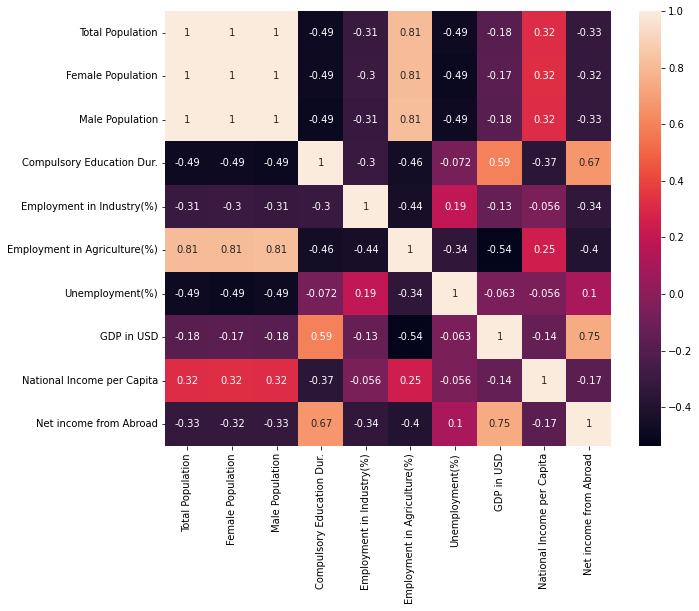

In [ ]:
# Checking with correlation matrix using heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(combined_df.corr(), annot=True)

Above correlation matrix infers following things - 
- There is a very high correlation between the total population and male and female population. It is as expected because Total population = Female population + Male Population

Hence keeping just total population, and removing the Female and male population columns for the analysis.

In [ ]:
combined_df = combined_df.drop(columns =['Female Population','Male Population'])

Text(0.5, 1.0, 'Correlation with GDP \n')

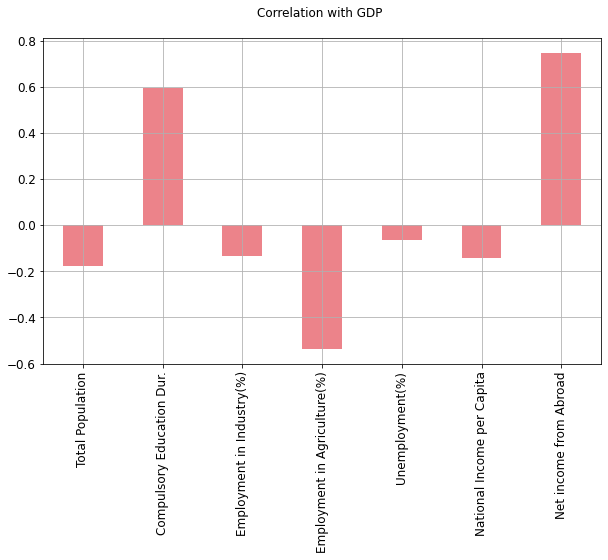

In [ ]:
# Checking how are the features related to GDP, whether they are positively correlated or negatively correlated
correlations = combined_df.corrwith(combined_df['GDP in USD'])
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (10, 6), 
        fontsize = 12, 
        color = '#ec838a',
        rot = 90, grid = True)
plt.title('Correlation with GDP \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "12", fontfamily = "sans-serif")

From the above visualization, we can infer following things -
- The highest positive correlation with GDP is shown by net income from abroad. It is as expected, because as the net income from abroad increases the GDP will also increase.
- Same is the case with compulsory education duration. As the country raises its compulsory education duration GDP will also increase as it will have lot of educated individuals.
- Other obvious conclusion is that unemployment is negatively correlated. Hence as unemployment increases, GDP decreases. Also same is the case with population, as population increases, GDP decreases.
- Interesting observation is that, Employment in Agriculture is negatively correlated. GDP will decrease if Employment in agriculture increases. Same is the case with Employment in industry, but is it minimally correlated.
- Another interesting fact is that national income per capita also show minimal negative correlation with GDP.

In [ ]:
def plot_bar(feature):
  df_new = combined_df.groupby('Country')[feature].mean()
  country_list = ['China','India','Russia','USA']
  # bar plot
  plt.figure(figsize=(5, 5))
  plt.title(feature + " for each country \n")
  sns.set(style="whitegrid")
  ax = sns.barplot(x=country_list, y=df_new)

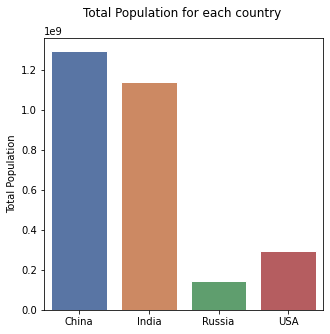

In [ ]:
plot_bar('Total Population')

- Population in China is the highest, followed by India
- Russia and USA have comparitively low population

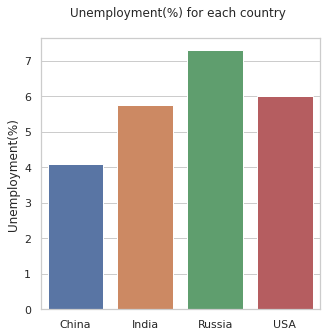

In [ ]:
plot_bar('Unemployment(%)')

- Unemployment percentage in Russia is highest, while China has minimum unemployment percentage.
- India and USA show similar pattern

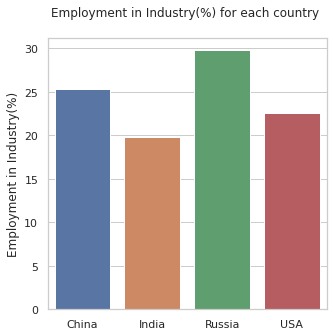

In [ ]:
plot_bar('Employment in Industry(%)')

- We can infer that Employment in industry is higher in Russia followed by China and then USA. Lastly India has minimum employment in industry compared to the rest of the countries according to the data.

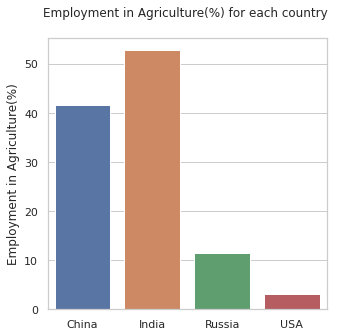

In [ ]:
plot_bar('Employment in Agriculture(%)')

- India ranks highest in employment in agriculture followed by China.
- USA has least employment in agriculture

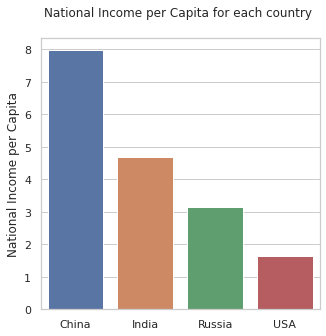

In [ ]:
plot_bar('National Income per Capita')

- National income per capita for China is highest and that of USA is minimum

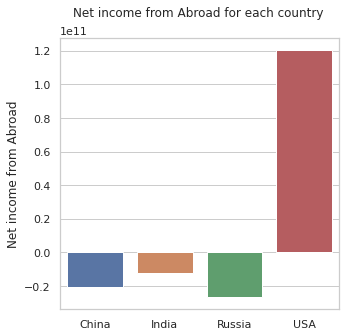

In [ ]:
plot_bar('Net income from Abroad')

- Only USA gets income from abroad.
- Other countries do not get income from abroad from the data

Let us try to visualize GDP for 4 countries according to the year.

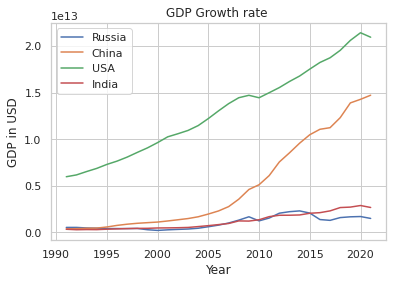

In [ ]:
country_set = set(combined_df['Country'])

plt.figure()
for country in country_set:
     selected_data = combined_df.loc[combined_df['Country'] == country]
     plt.plot(selected_data['Year'], selected_data['GDP in USD'], label=country)
     
plt.legend()
plt.title('GDP Growth rate ')
plt.ylabel('GDP in USD')
plt.xlabel('Year')
plt.show()

- From the above graph we can say that, there is steep increase in the GDP for USA and China for the past 31 years.
- India and Russia comparitively do not vary much

In order to predict the GDP in USD, we will have to check if the data is stationary, if not we will convert it into stationary.

# Task 4 - Time Series Analysis

**Check if data is stationary Using ACF**

Serial dependency is implied by autocorrelation(ACF). It happens when a time series' lagged version is substantially associated with the original. The acf plot illustrates this. The higher the bar in the acf plot, the more a series is dependent.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


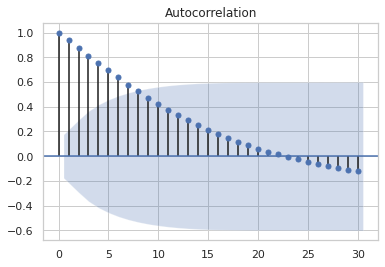

In [ ]:
import pandas.util.testing as tm
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(combined_df['GDP in USD'],lags=30)
plt.show()

The ACF value is very high, close to one, and it is decreasing slowly.

This is the case of a non-stationary series.

**Check if GDP data is stationary Using ADF Test**

Augmented Dickey-Fuller Test - The Augmented Dickey-Fuller test is one of the most popular tests to check for stationarity. It tests the below hypothesis.

Null Hypothesis, H0: The time series is not stationary.

Alternative Hypothesis, H1: The time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

stat_test = adfuller(combined_df['GDP in USD'])
print('ADF Test Statistic: %.2f' % stat_test[0])
print('5%% Critical Value: %.2f' % stat_test[4]['5%'])
print('p-value: %.2f' % stat_test[1])

ADF Test Statistic: -2.63
5% Critical Value: -2.89
p-value: 0.09


The p-value is greater than 0.05 or the absolute value of the test statistics is less than the critical value, you fail to reject H0 and conclude that the time series is not stationary.

**If the series is not stationary, making it stationary by taking the difference**

Since stationary series are easy to analyze, you can convert a non-stationary series into a stationary series by the method of Differencing. In fact, it is necessary to convert a non-stationary series into a stationary series in order to use time series forecasting models.

In [ ]:
from statsmodels.tsa.stattools import adfuller

stat_test = adfuller(combined_df['GDP in USD'].diff().dropna())
print('ADF Test Statistic: %.2f' % stat_test[0])
print('5%% Critical Value: %.2f' % stat_test[4]['5%'])
print('p-value: %.2f' % stat_test[1])

ADF Test Statistic: -10.48
5% Critical Value: -2.89
p-value: 0.00


**Check if the data is normally distributed using QQ Plot**

((array([-2.53517899, -2.20753392, -2.01898447, -1.88299617, -1.77490883,
         -1.68429332, -1.6057127 , -1.53595628, -1.47296247, -1.41532506,
         -1.36204   , -1.31236409, -1.2657311 , -1.22169913, -1.17991637,
         -1.14009786, -1.1020094 , -1.06545597, -1.03027338, -0.99632194,
         -0.96348179, -0.93164919, -0.90073374, -0.87065609, -0.8413462 ,
         -0.81274187, -0.78478758, -0.75743353, -0.73063483, -0.70435089,
         -0.67854479, -0.65318287, -0.62823433, -0.60367085, -0.57946634,
         -0.55559668, -0.53203947, -0.50877391, -0.48578055, -0.46304122,
         -0.44053886, -0.41825741, -0.39618171, -0.37429744, -0.352591  ,
         -0.33104944, -0.30966043, -0.28841218, -0.26729336, -0.24629309,
         -0.2254009 , -0.20460664, -0.18390049, -0.1632729 , -0.14271455,
         -0.12221635, -0.10176938, -0.08136487, -0.06099419, -0.04064878,
         -0.02032019,  0.        ,  0.02032019,  0.04064878,  0.06099419,
          0.08136487,  0.10176938,  0.

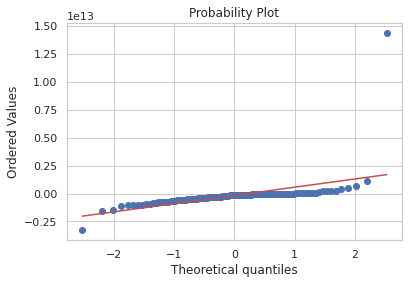

In [ ]:
# Use QQ plot and see if the gdp in usd follow normal distribution
from scipy import stats
stats.probplot(combined_df['GDP in USD'].diff().dropna(), plot=plt)

The data is normally distributed, if the points in the QQ-normal plot lie on a straight line. Here, from the QQ Plot we can say that data is normally distributed.

# Task 5 - Machine Learning - Predicting GDP in USD

**Label Encode Categorical data**:

Machine Learning algorithms can typically only have numerical values as their independent variables. Hence label encoding is quite pivotal as they encode categorical labels with appropriate numerical values. Here we are label encoding all categorical variables.

In [ ]:
from sklearn.preprocessing import LabelEncoder
#Create a label encoder object
le = LabelEncoder()
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
print("Columns encoded")
for col in combined_df.columns[1:]:
    if combined_df[col].dtype == 'object':
            le.fit(combined_df[col])
            combined_df[col] = le.transform(combined_df[col])
            le_count += 1
            print(col)
print('{} columns were label encoded.'.format(le_count))

Columns encoded
Year
Country
2 columns were label encoded.


**Split the dataset into dependent and independent variables**:

Now we need to separate the dataset into X and y values. y would be the GDP column while X would be the remaining list of independent variables in the dataset.

In [ ]:
target = combined_df['GDP in USD'].dropna()
dataset = combined_df.drop(columns=['GDP in USD'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size = 0.2, random_state = 0)
#to resolve any class imbalance - use stratify parameter.
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (99, 9)
Number transactions y_train dataset:  (99,)
Number transactions X_test dataset:  (25, 9)
Number transactions y_test dataset:  (25,)


**Conduct Feature Scaling:**

It’s quite important to normalize the variables before conducting any machine learning algorithms so that all the training and test variables are scaled within a range of 0 to 1.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2


**Implementing Linear Regression model on the dataset.**
- First train the model on the training data using fit()
- Predict the values on the test data

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=0)
 
LR =lr.fit(X_train,y_train)
 
y_pred = lr.predict(X_test)

from sklearn import metrics
print('ROOT MEAN SQUARE ERROR:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
 
from sklearn.metrics import r2_score
print('R SQUARE:',r2_score(y_test,y_pred))


ROOT MEAN SQUARE ERROR: 2191078827698.315
R SQUARE: 0.8862983230634949


RMSE or Root Mean Square Error is the measure of how well a regression line fits the data points

We can see that Linear Regression model gives R square of 0.88, which is acceptable.

Lets check with OLS, the summary statistics of the model

In [ ]:
import statsmodels.api as sm
LR =sm.OLS(y_test,y_pred).fit()
LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             GDP in USD   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              365.5
Date:                Wed, 30 Mar 2022   Prob (F-statistic):                    4.98e-16
Time:                        18:53:33   Log-Likelihood:                         -744.64
No. Observations:                  25   AIC:                                      1491.
Df Residuals:                      24   BIC:                                      1492.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9242      0.048     19.117      0.000       0.824       1.024
==============================================================================
Omnibus:                        4.787   Durbin-Watson:                   2.611
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                2.918
Skew:                           0.614   Prob(JB):                        0.232
Kurtosis:                       4.137   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**R – squared value**: 
R2 is the coefficient of determination that tells us that how much percentage variation independent variable can be explained by independent variable. Here, 93.8 % variation in GDP can be explained by rest of the dataset. The maximum possible value of R2  can be 1, means the larger the R2  value better the regression.

**Adjusted R-squared** It is important for analyzing multiple dependent variables’ efficacy on the model

**F – statistic**: 
F test tells the goodness of fit of a regression. The test is similar to the t-test or other tests we do for the hypothesis.

In [ ]:
data = pd.DataFrame(data={"Predicted GDP in USD": y_pred.flatten()})

In [ ]:
# Predicted values
data.head(10)

,Predicted GDP in USD
0,1.835962e+13
1,1.061910e+12
2,3.753782e+12
3,6.986310e+12
4,9.108848e+12
5,5.164471e+12
6,-4.124518e+11
7,3.945155e+10
8,1.832325e+13
9,-2.593368e+11


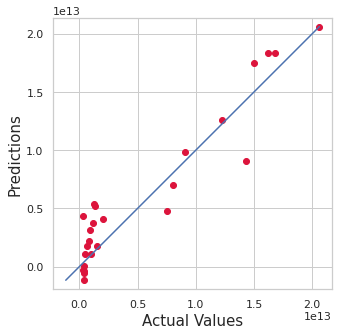

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-') # regression line
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

The Predicted values are close to regression line